Build slim interactions (Parquet) + user like-counts with CHUNKS (Low-RAM)

In [1]:
import os, re, glob, gc
import numpy as np
import pandas as pd
from collections import Counter
import pyarrow as pa, pyarrow.parquet as pq

# beer_mat / beer_ids 로드 (없으면 업로드)
mat_path, ids_path = "/content/beer_mat.npy", "/content/beer_ids.npy"
if not (os.path.exists(mat_path) and os.path.exists(ids_path)):
    from google.colab import files
    print(">> beer_mat.npy / beer_ids.npy 파일 업로드")
    files.upload()
beer_mat = np.load(mat_path, mmap_mode="r")
beer_ids = np.load(ids_path, allow_pickle=True)
print("beer_mat:", beer_mat.shape, "| beer_ids:", beer_ids.shape)

# KaggleHub에서 리뷰 파일 위치 찾기
try:
    import kagglehub
except Exception:
    !pip -q install kagglehub
    import kagglehub

path = kagglehub.dataset_download("ehallmar/beers-breweries-and-beer-reviews")
print("kagglehub path:", path)

cands = []
cands += glob.glob(os.path.join(path, "**/*reviews*.csv"), recursive=True)
cands += glob.glob(os.path.join(path, "**/*review*.csv"),  recursive=True)
cands += glob.glob(os.path.join(path, "**/*reviews*.csv.gz"), recursive=True)
assert cands, "리뷰 파일을 찾지 못했습니다."
reviews_path = sorted(cands)[0]
print("reviews file:", reviews_path)

SLIM_OUT = "/content/df_for_cf.slim.parquet"     # (user,item,rating)만 저장
if os.path.exists(SLIM_OUT):
    os.remove(SLIM_OUT)
writer = None
schema = None

LIKE_THR = 4.0
like_counter = Counter()

# 청크 읽기 + 정규화 + 슬림 저장 + 유저 좋아요 카운트
CHUNK = 1_000_000
chunk_iter = pd.read_csv(reviews_path, chunksize=CHUNK, low_memory=True)

for ci, chunk in enumerate(chunk_iter, start=1):
    chunk.columns = [re.sub(r"[^0-9a-z]+", "_", str(c).strip().lower()) for c in chunk.columns]
    cols = set(chunk.columns)

    if "username" not in cols or "beer_id" not in cols:
        user_col = "review_profilename" if "review_profilename" in cols else "username"
        item_col = "beer_beerid" if "beer_beerid" in cols else ("beer_id" if "beer_id" in cols else None)
    else:
        user_col, item_col = "username", "beer_id"

    rating_col = "overall" if "overall" in cols else ("score" if "score" in cols else None)
    if item_col is None or rating_col is None:
        print(f"[skip chunk {ci}] columns={list(cols)[:10]}")
        continue

    slim = chunk[[user_col, item_col, rating_col]].rename(
        columns={user_col:"user", item_col:"item", rating_col:"rating"}
    )
    slim["rating"] = pd.to_numeric(slim["rating"], errors="coerce").astype("float32")
    slim = slim.dropna(subset=["user","item","rating"])

    like_counter.update(slim.loc[slim["rating"] >= LIKE_THR, "user"].astype(str).tolist())

    # Parquet로 RowGroup append
    tbl = pa.Table.from_pandas(slim[["user","item","rating"]], preserve_index=False)
    if writer is None:
        schema = tbl.schema
        writer = pq.ParquetWriter(SLIM_OUT, schema)
    writer.write_table(tbl)
    del chunk, slim, tbl
    if ci % 2 == 0:
        gc.collect()
    if ci % 5 == 0:
        print(f"[chunk {ci}] wrote row-groups so far...")

if writer: writer.close()
print("Wrote slim interactions:", SLIM_OUT)

# 유저 좋아요 카운트 저장 (Parquet)
u_like_df = pd.DataFrame(list(like_counter.items()), columns=["user","like_ge_thr"])
u_like_df.to_parquet("/content/user_like_counts.parquet", index=False)
print("Wrote user like counts:", u_like_df.shape)


>> beer_mat.npy / beer_ids.npy 파일 업로드


Saving beer_mat.npy to beer_mat.npy
Saving beer_ids.npy to beer_ids.npy
beer_mat: (358873, 114) | beer_ids: (358873,)


100%|██████████| 810M/810M [00:09<00:00, 93.2MB/s]

Extracting files...


kagglehub path: /root/.cache/kagglehub/datasets/ehallmar/beers-breweries-and-beer-reviews/versions/2
reviews file: /root/.cache/kagglehub/datasets/ehallmar/beers-breweries-and-beer-reviews/versions/2/reviews.csv
[chunk 5] wrote row-groups so far...
[chunk 10] wrote row-groups so far...
Wrote slim interactions: /content/df_for_cf.slim.parquet
Wrote user like counts: (99363, 2)


FAST multi-user Top-K from slim Parquet (stream), incremental write

In [2]:
import numpy as np, pandas as pd, gc, os
import pyarrow as pa, pyarrow.parquet as pq, pyarrow.dataset as ds

# 로드(아이템 임베딩 + 슬림 상호작용 + 유저카운트)
beer_mat = np.load("/content/beer_mat.npy", mmap_mode="r")
beer_ids = np.load("/content/beer_ids.npy", allow_pickle=True)
SLIM_IN   = "/content/df_for_cf.slim.parquet"
USERCOUNT = "/content/user_like_counts.parquet"
assert os.path.exists(SLIM_IN) and os.path.exists(USERCOUNT), "Cell 1 산출물이 필요합니다."

# beer_id -> 행 인덱스 매핑
try:
    bid2idx = {int(b): i for i, b in enumerate(beer_ids)}
except Exception:
    bid2idx = {str(b): i for i, b in enumerate(beer_ids)}

dataset = ds.dataset(SLIM_IN, format="parquet")  # schema: user(str), item, rating(float32)
user_like = pd.read_parquet(USERCOUNT)           # user별 like>=thr 개수

# 하이퍼파라미터
LIKE_THR  = 4.0
TOP_USERS = 200     # 200명으로 설정했으나 확대가능
TOP_K     = 100
OUT_PATH  = "/content/cb_topk.parquet"


top_users = (user_like.sort_values("like_ge_thr", ascending=False)
                       .head(TOP_USERS)["user"].astype(str).tolist())
print("n_top_users:", len(top_users))

def get_user_rows(uid: str):
    """ondisk dataset에서 user=uid 행만 읽어 (beer_id, rating) 반환"""
    flt = (ds.field("user") == uid)
    tbl = dataset.to_table(filter=flt, columns=["item","rating"])
    if tbl.num_rows == 0:
        return np.array([], dtype=object), np.array([], dtype=np.float32)
    df = tbl.to_pandas()
    # 타입 정리
    items  = df["item"].to_numpy(copy=False)
    rating = pd.to_numeric(df["rating"], errors="coerce").astype(np.float32).to_numpy(copy=False)
    return items, rating

def build_user_vec(uid: str):
    items, rating = get_user_rows(uid)
    if items.size == 0:
        return None, None
    m = rating >= LIKE_THR
    if not m.any():
        return None, items
    bids = items[m]
    idx  = np.fromiter((bid2idx.get(int(b), -1) for b in bids), dtype=np.int64, count=bids.size)
    idx  = idx[idx >= 0]
    if idx.size == 0:
        return None, items
    w = (rating[m][:idx.size] - 3.5).clip(min=0).astype(np.float32)
    u = (beer_mat[idx] * w[:, None]).sum(axis=0)
    n = np.linalg.norm(u)
    return (u / n).astype(np.float32) if n > 0 else None, items

def topk_for_user(uid: str, K=TOP_K):
    Uvec, seen_items = build_user_vec(uid)
    if Uvec is None:
        return None
    # 본 아이템 제외
    if seen_items.size:
        seen_idx = np.fromiter((bid2idx.get(int(b), -1) for b in seen_items), dtype=np.int64, count=seen_items.size)
        seen_idx = seen_idx[seen_idx >= 0]
    else:
        seen_idx = np.array([], dtype=np.int64)

    s = beer_mat @ Uvec
    if seen_idx.size:
        s[seen_idx] = -np.inf

    k = min(K, s.size)
    idx = np.argpartition(-s, k-1)[:k]
    idx = idx[np.argsort(-s[idx])]
    return pd.DataFrame({
        "user_id": uid,
        "beer_id": beer_ids[idx],
        "cb_similarity_score": s[idx].astype(np.float32)
    }, copy=False)

if os.path.exists(OUT_PATH):
    os.remove(OUT_PATH)
writer = None
written = 0
for uid in top_users:
    df = topk_for_user(uid)
    if df is None or df.empty:
        continue
    tbl = pa.Table.from_pandas(df, preserve_index=False)
    if writer is None:
        writer = pq.ParquetWriter(OUT_PATH, tbl.schema)
    writer.write_table(tbl)
    written += len(df)
    del df, tbl
    if written % 10000 == 0:
        gc.collect()

if writer:
    writer.close()
print("Saved:", OUT_PATH, "rows:", written)

# 빠른 검증
test = pd.read_parquet(OUT_PATH)
print(test.shape, "unique_users:", test["user_id"].nunique())
print(test.head(3))



n_top_users: 200
Saved: /content/cb_topk.parquet rows: 20000
(20000, 3) unique_users: 200
         user_id  beer_id  cb_similarity_score
0  StonedTrippin   366894             0.999565
1  StonedTrippin   115394             0.999440
2  StonedTrippin   311921             0.999362


In [3]:
from google.colab import files
files.download("/content/cb_topk.parquet")
files.download("/content/df_for_cf.slim.parquet")
files.download("/content/user_like_counts.parquet")
# 이미 받아둔 임베딩
files.download("/content/beer_mat.npy")
files.download("/content/beer_ids.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
OUT_PATH = "/content/cb_topk_u1000_k200.parquet"

Robust demo & summary rebuild

In [4]:
import os, glob, re
import pandas as pd

# 0) Top-K 결과 경로 (이미 만들어둔 파일)
TOPK_PATH = "/content/cb_topk.parquet"
assert os.path.exists(TOPK_PATH), "cb_topk.parquet 이 필요합니다. (셀2에서 생성)"

# 1) beers.csv 탐색
BASE_CANDIDATES = [
    "/kaggle/input/beers-breweries-and-beer-reviews",
    "/root/.cache/kagglehub/datasets/ehallmar/beers-breweries-and-beer-reviews/versions/2",
    "/root/.cache/kagglehub/datasets/ehallmar/beers-breweries-and-beer-reviews",
]
beers_path = None
for base in BASE_CANDIDATES:
    if os.path.exists(base):
        cands = []
        cands += glob.glob(os.path.join(base, "**/beers*.csv"), recursive=True)
        cands += glob.glob(os.path.join(base, "**/beers*.csv.gz"), recursive=True)
        if cands:
            beers_path = sorted(cands)[0]; break

if beers_path is None:
    try:
        import kagglehub
    except Exception:
        !pip -q install kagglehub
        import kagglehub
    base = kagglehub.dataset_download("ehallmar/beers-breweries-and-beer-reviews")
    cands = []
    cands += glob.glob(os.path.join(base, "**/beers*.csv"), recursive=True)
    cands += glob.glob(os.path.join(base, "**/beers*.csv.gz"), recursive=True)
    beers_path = sorted(cands)[0] if cands else None

assert beers_path is not None, "beers.csv 파일을 찾지 못했습니다."

# 2) beers.csv 읽고 컬럼 정규화, 매핑)
if beers_path.endswith(".gz"):
    beers_df = pd.read_csv(beers_path, low_memory=False, compression="infer")
else:
    beers_df = pd.read_csv(beers_path, low_memory=False)

beers_df.columns = [re.sub(r"[^0-9a-z]+", "_", str(c).strip().lower()) for c in beers_df.columns]

def pick(colset, aliases, label):
    for a in aliases:
        if a in colset: return a
    raise KeyError(f"'{label}'에 해당하는 컬럼을 찾지 못했습니다. 실제: {list(colset)[:10]}")

cols = set(beers_df.columns)
beer_id_col = pick(cols, ["beer_id","beerid","id","beer_beerid","beer_beer_id"], "beer_id")
name_col    = pick(cols, ["name","beer_name","title"], "name")
style_col   = pick(cols, ["style","beer_style"], "style")
abv_col     = pick(cols, ["abv","alcohol_by_volume","alc","alc_by_vol"], "abv")

beers = (beers_df[[beer_id_col, name_col, style_col, abv_col]]
         .rename(columns={beer_id_col:"beer_id", name_col:"name", style_col:"style", abv_col:"abv"}))
beers["abv"] = pd.to_numeric(beers["abv"], errors="coerce")

# 3) Top-K 결과
topk = pd.read_parquet(TOPK_PATH)  # user_id, beer_id, cb_similarity_score

# 4) 데모(사용자 3명 Top-10) & 스타일 요약표
demo_users = topk["user_id"].unique()[:3]
demo = (topk[topk["user_id"].isin(demo_users)]
        .merge(beers, on="beer_id", how="left")
        .sort_values(["user_id","cb_similarity_score"], ascending=[True, False]))
demo_top10 = demo.groupby("user_id").head(10)

# style 컬럼명 처리
style_col_in_demo = "style" if "style" in demo.columns else [c for c in demo.columns if c.startswith("style")][0]
cnt = (demo.groupby(["user_id", style_col_in_demo]).size()
          .rename("cnt").reset_index())
cnt["ratio"] = (cnt["cnt"] / cnt.groupby("user_id")["cnt"].transform("sum")).round(2)
style_ratio = cnt.rename(columns={style_col_in_demo:"style"}) \
                 .sort_values(["user_id","ratio"], ascending=[True, False])


demo_top10.to_csv("/content/cb_demo_top10.csv", index=False)
style_ratio.to_csv("/content/cb_style_ratio.csv", index=False)
print("Saved /content/cb_demo_top10.csv  /content/cb_style_ratio.csv")


print("\n[DEMO Top-10 sample]")
print(demo_top10.head(20))
print("\n[Style ratio sample]")
print(style_ratio.groupby("user_id").head(5).head(20))


Saved /content/cb_demo_top10.csv  /content/cb_style_ratio.csv

[DEMO Top-10 sample]
           user_id  beer_id  cb_similarity_score  \
200          Sammy   366894             0.999690   
201          Sammy   368014             0.999595   
202          Sammy   311921             0.999593   
203          Sammy   368012             0.999592   
204          Sammy   365307             0.999590   
205          Sammy   104620             0.999539   
206          Sammy    89801             0.999520   
207          Sammy   340204             0.999505   
208          Sammy    83277             0.999500   
209          Sammy    73368             0.999488   
0    StonedTrippin   366894             0.999565   
1    StonedTrippin   115394             0.999440   
2    StonedTrippin   311921             0.999362   
3    StonedTrippin   368012             0.999354   
4    StonedTrippin   368014             0.999353   
5    StonedTrippin   365307             0.999351   
6    StonedTrippin   104620     

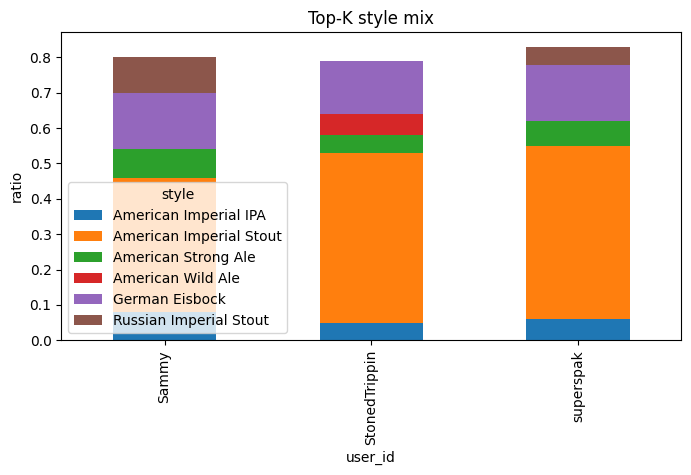

In [23]:
# 사용자별 top 5 시각화
top5 = style_ratio.groupby("user_id").head(5)
pivot = top5.pivot(index="user_id", columns="style", values="ratio").fillna(0)
ax = pivot.plot(kind="bar", stacked=True, figsize=(8,4), ylabel="ratio", xlabel="user_id", title="Top-K style mix")


CB Evaluation: Setup

In [5]:
import os, gc, math
import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.parquet as pq

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score

# --- Paths
BEER_MAT_PATH  = "/content/beer_mat.npy"
BEER_IDS_PATH  = "/content/beer_ids.npy"
SLIM_PARQUET   = "/content/df_for_cf.slim.parquet"

assert os.path.exists(BEER_MAT_PATH) and os.path.exists(BEER_IDS_PATH), "beer_mat / beer_ids가 필요합니다."
assert os.path.exists(SLIM_PARQUET), "df_for_cf.slim.parquet이 필요합니다."

# --- Load item embedding
beer_mat = np.load(BEER_MAT_PATH, mmap_mode="r")        # (n_items, d), row L2-normalized
beer_ids = np.load(BEER_IDS_PATH, allow_pickle=True)     # shape (n_items,)

# beer_id -> row index
try:
    bid2idx = {int(b): i for i, b in enumerate(beer_ids)}
except Exception:
    bid2idx = {str(b): i for i, b in enumerate(beer_ids)}

# --- Load interactions dataset (ondisk, streaming)
dataset = ds.dataset(SLIM_PARQUET, format="parquet")     # columns: user, item, rating (float32)

# --- Evaluation Parameters (프로포절 정렬)
LIKE_THR        = 4.0     # Like 기준 (binary label)
TEST_FRACTION   = 0.20    # 80/20 홀드아웃
RANDOM_SEED     = 42
MIN_LIKES_TRAIN = 1       # train에 최소 like 개수(유저 프로파일 만들기 위한 최소치)
TOP_N_LIST      = [10, 20]
MAX_USERS       = 200     # 테스트할 사용자 수(속도 위해 200~500 권장). 전체면 None

rng = np.random.default_rng(RANDOM_SEED)

# --- Utility: build user vector from (beer_ids, ratings) on TRAIN only
def build_user_vec(train_items: np.ndarray, train_ratings: np.ndarray, like_thr: float = LIKE_THR):
    if train_items.size == 0:
        return None
    # Like 필터
    m_like = train_ratings >= like_thr
    if not m_like.any():
        return None
    bids = train_items[m_like]
    # map to embedding rows
    idx = np.fromiter((bid2idx.get(int(b), -1) for b in bids), dtype=np.int64, count=bids.size)
    idx = idx[idx >= 0]
    if idx.size == 0:
        return None
    # weights = (rating - 3.5)+
    w = (train_ratings[m_like][:idx.size] - 3.5)
    w = np.clip(w, a_min=0.0, a_max=None).astype(np.float32)
    if w.sum() == 0:
        return None
    u = (beer_mat[idx] * w[:, None]).sum(axis=0)   # (d,)
    n = np.linalg.norm(u)
    if n == 0:
        return None
    return (u / n).astype(np.float32)

# --- Utility: score items given user vector (cosine via dot)
def score_items(user_vec: np.ndarray, candidate_idx: np.ndarray):
    # beer_mat is row-normalized → dot equals cosine
    return (beer_mat[candidate_idx] @ user_vec).astype(np.float32)


CB Evaluation — 80/20 Holdout + AUC/PR/F1 + Precision@N/Recall@N

In [6]:
import os, gc, numpy as np, pandas as pd
import pyarrow.dataset as ds
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score

# ---------- Paths  ----------
SLIM_PARQUET = "/content/df_for_cf.slim.parquet"
assert os.path.exists(SLIM_PARQUET), "df_for_cf.slim.parquet 이 필요합니다."

# ---------- Preloaded from Cell 1 : beer_mat, beer_ids, bid2idx ----------
# beer_mat: (n_items, d) row L2-normalized numpy memmap
# beer_ids: (n_items,) item id array
# bid2idx : dict(beer_id -> row index)
assert 'beer_mat' in globals() and 'beer_ids' in globals() and 'bid2idx' in globals(), \
    "셀1에서 beer_mat/beer_ids/bid2idx 를 먼저 로드해 주세요."

# ---------- Evaluation Params ----------
LIKE_THR        = 4.0
TEST_FRACTION   = 0.20
RANDOM_SEED     = 42
TOP_N_LIST      = [10, 20]
MAX_USERS       = 200
rng = np.random.default_rng(RANDOM_SEED)

# ---------- Helpers ----------
def build_user_vec(train_items: np.ndarray, train_ratings: np.ndarray, like_thr: float = LIKE_THR):
    """Train의 좋아요만으로 유저 벡터 생성; 없으면 None."""
    if train_items.size == 0:
        return None
    m_like = train_ratings >= like_thr
    if not m_like.any():
        return None
    bids = train_items[m_like]
    idx = np.fromiter((bid2idx.get(int(b), -1) for b in bids), dtype=np.int64, count=bids.size)
    idx = idx[idx >= 0]
    if idx.size == 0:
        return None
    w = (train_ratings[m_like][:idx.size] - 3.5)
    w = np.clip(w, 0.0, None).astype(np.float32)
    if w.sum() == 0:
        return None
    u = (beer_mat[idx] * w[:, None]).sum(axis=0)
    n = np.linalg.norm(u)
    if n == 0:
        return None
    return (u / n).astype(np.float32)

def score_items(user_vec: np.ndarray, candidate_idx: np.ndarray):
    """row-normalized beer_mat이므로 dot = cosine."""
    return (beer_mat[candidate_idx] @ user_vec).astype(np.float32)

# ---------- Load dataset (ondisk) ----------
dataset = ds.dataset(SLIM_PARQUET, format="parquet")  # columns: user, item, rating

# ---------- Collect users (unique, streaming) ----------
users = []
scanner = dataset.scanner(columns=["user"])
for batch in scanner.to_batches():
    users.extend(batch.column(0).to_pylist())
users = pd.Series(users, dtype="object").astype(str).unique()
if MAX_USERS is not None:
    users = users[:MAX_USERS]
print(f"[INFO] #users to evaluate: {len(users)}")

# ---------- Accumulators ----------
y_true_all, y_score_all = [], []
rank_prec = {N: [] for N in TOP_N_LIST}
rank_reca = {N: [] for N in TOP_N_LIST}

# ---------- Per-user evaluation ----------
processed = 0
for uid in users:
    tbl = dataset.to_table(filter=(ds.field("user") == uid))
    if tbl.num_rows == 0:
        continue
    dfu = tbl.to_pandas()
    items = dfu["item"].to_numpy()
    ratings = pd.to_numeric(dfu["rating"], errors="coerce").to_numpy(dtype=np.float32)
    n = items.size
    if n < 2:
        continue

    # (b) Hold-out 80/20 split
    test_mask = rng.random(n) < TEST_FRACTION
    if not test_mask.any() or test_mask.all():
        test_mask[:] = False
        test_mask[rng.integers(0, n)] = True

    train_items, train_ratings = items[~test_mask], ratings[~test_mask]
    test_items , test_ratings  = items[test_mask],  ratings[test_mask]

    # (c) user vector from TRAIN likes only
    uvec = build_user_vec(train_items, train_ratings, like_thr=LIKE_THR)
    if uvec is None:
        continue

    # -------- Classification on TEST (AUC/PR/F1용 y_true/y_score 수집) --------
    test_idx = np.fromiter((bid2idx.get(int(b), -1) for b in test_items), dtype=np.int64, count=test_items.size)
    keep = test_idx >= 0
    if keep.any():
        test_idx = test_idx[keep]
        y_true = (test_ratings[keep] >= LIKE_THR).astype(np.int8)
        y_score = score_items(uvec, test_idx)
        y_true_all.append(y_true)
        y_score_all.append(y_score)

    # -------- Ranking (Top-N): Train에서 본 아이템만 제외 --------
    seen_train_idx = np.fromiter((bid2idx.get(int(b), -1) for b in train_items),
                                 dtype=np.int64, count=train_items.size)
    seen_train_idx = seen_train_idx[seen_train_idx >= 0]

    s_all = beer_mat @ uvec
    if seen_train_idx.size:
        s_all[seen_train_idx] = -np.inf

    # test likes set
    test_likes = {int(b) for b, r in zip(test_items, test_ratings) if r >= LIKE_THR}
    if len(test_likes) > 0:
        for N in TOP_N_LIST:
            nN = min(N, s_all.size)
            top_idx = np.argpartition(-s_all, nN-1)[:nN]
            top_idx = top_idx[np.argsort(-s_all[top_idx])]
            top_beers = [beer_ids[i] for i in top_idx]
            hits = sum(1 for b in top_beers if int(b) in test_likes)
            rank_prec[N].append(hits / nN)
            rank_reca[N].append(hits / len(test_likes))

    processed += 1
    if processed % 500 == 0:
        gc.collect()

# ---------- Classification metrics (global) ----------
if len(y_true_all) == 0:
    raise RuntimeError("테스트 샘플이 없어 분류 지표를 계산할 수 없습니다.")
y_true_all  = np.concatenate(y_true_all).astype(np.int8)
y_score_all = np.concatenate(y_score_all).astype(np.float32)

try:
    auc_roc = roc_auc_score(y_true_all, y_score_all)
except ValueError:
    auc_roc = float("nan")
pr_auc = average_precision_score(y_true_all, y_score_all)

pred_05 = (y_score_all >= 0.5).astype(int)
prec_05, reca_05, f1_05, _ = precision_recall_fscore_support(
    y_true_all, pred_05, average="binary", zero_division=0
)

prec_curve, reca_curve, thr_curve = precision_recall_curve(y_true_all, y_score_all)
f1_curve = (2 * prec_curve * reca_curve) / np.clip(prec_curve + reca_curve, 1e-9, None)
best_idx = np.nanargmax(f1_curve)
best_f1  = float(f1_curve[best_idx])
best_thr = float(thr_curve[max(0, min(best_idx, len(thr_curve)-1))])
best_prec, best_reca = float(prec_curve[best_idx]), float(reca_curve[best_idx])

# ---------- Ranking metrics (macro avg over users) ----------
rank_summary = {}
for N in TOP_N_LIST:
    p = np.mean(rank_prec[N]) if rank_prec[N] else float("nan")
    r = np.mean(rank_reca[N]) if rank_reca[N] else float("nan")
    rank_summary[N] = {"precision@N": p, "recall@N": r}

# ---------- Print ----------
print("\n=== Classification (80/20 hold-out, global) ===")
print(f"AUC-ROC          : {auc_roc:.4f}")
print(f"PR-AUC           : {pr_auc:.4f}")
print(f"Prec/Rec/F1 @0.5 : {prec_05:.4f} / {reca_05:.4f} / {f1_05:.4f}")
print(f"Best-F1 threshold: {best_thr:.4f}  →  Prec={best_prec:.4f}  Rec={best_reca:.4f}  F1={best_f1:.4f}")

print("\n=== Ranking (Top-N, macro-avg over users) ===")
for N in TOP_N_LIST:
    print(f"Precision@{N}: {rank_summary[N]['precision@N']:.4f}   Recall@{N}: {rank_summary[N]['recall@N']:.4f}")

# ---------- Save ----------
pd.DataFrame({
    "auc_roc":[auc_roc],
    "pr_auc":[pr_auc],
    "prec_at_0_5":[prec_05],
    "recall_at_0_5":[reca_05],
    "f1_at_0_5":[f1_05],
    "best_thr":[best_thr],
    "best_prec":[best_prec],
    "best_recall":[best_reca],
    "best_f1":[best_f1],
}).to_csv("/content/cb_eval_classification.csv", index=False)

pd.DataFrame([
    {"N": N, "precision": rank_summary[N]["precision@N"], "recall": rank_summary[N]["recall@N"]}
    for N in TOP_N_LIST
]).to_csv("/content/cb_eval_ranking.csv", index=False)

print("\nSaved:", "/content/cb_eval_classification.csv", "and", "/content/cb_eval_ranking.csv")


[INFO] #users to evaluate: 200

=== Classification (80/20 hold-out, global) ===
AUC-ROC          : 0.6599
PR-AUC           : 0.7066
Prec/Rec/F1 @0.5 : 0.5655 / 1.0000 / 0.7224
Best-F1 threshold: 0.9804  →  Prec=0.5988  Rec=0.9139  F1=0.7235

=== Ranking (Top-N, macro-avg over users) ===
Precision@10: 0.0021   Recall@10: 0.0013
Precision@20: 0.0021   Recall@20: 0.0017

Saved: /content/cb_eval_classification.csv and /content/cb_eval_ranking.csv
